# 1. Introduction
For this project we were asked to select a dataset and using the data answer a question of our choosing. I selected the Titanic Data Set which looks at the characteristics of a sample of the passengers on the Titanic, including whether they survived or not, gender, age, siblings / spouses, parents and children, fare (cost of ticket), embarkation port.

After looking at the contents of the dataset, I thought it would be interesting to look at the following questions:
- Which gender had a better chance of survival?
- Which social class had a better chance of survival?
- Which age group had a better chance of survival?


# 2. Setting up report
In order to analyse and report on the data, I have choosen to use ipython notebook, along with the numpy, pandas, matplotlib.pyplot and seaborn python modules.
In order to use these modules they needed to be imported into the notebook first as per below.

In [122]:
#importing of required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
from numbers import Number
from scipy import stats
#allow plots and visualisations to be displayed in the report
%pylab inline



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [123]:
def as_percent(val, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(val, Number):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

# 3. Read CSV into dataframe

In [124]:
# Read csv into Pandas Dataframe and store in dataset variable
titanic_df = pd.read_csv('titanic_data.csv')

# 4. Data Wrangling / Cleaning
Before working with the data I needed to look at what needed to be cleaned up, i.e. find missing data, remove data that will not assist with the analysis.
## 4.1 Investigating Dataset and finding missing / incomplete data

In [125]:
# print out information about the data
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


After printing out the dataset information above, we can see that the Age, Cabin and Embarked columns are missing entries. As the Cabin column is not relevant to the analysis of the data I will be removing that column however I will need to find a way update populate the missing ages and embarked port.

## 4.2 Missing Ages
In order to populate the missing ages I will use the mean age based on the Sex and Pclass

In [126]:
missing_ages = titanic_df[titanic_df['Age'].isnull()]
# determine mean age based on Sex and Pclass
mean_ages = titanic_df.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(row):
    '''
    function to check if the age is null and replace wth the mean from 
    the mean ages dataframe 
    '''
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'],row['Pclass']]
    else:
        return row['Age']

titanic_df['Age'] =titanic_df.apply(remove_na_ages, axis=1)

## 4.3 Missing embarkation ports
In order to populate the missing embarked ports I need to first determine if the people with the missing information may have been travelling with others.

In [127]:
missing_ports = titanic_df[titanic_df['Embarked'].isnull()]
missing_ports

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN


In [128]:
# search by ticket number and cabin
titanic_df[(titanic_df['Embarked'].notnull()) & ((titanic_df['Ticket'] == '113572') | (titanic_df['Cabin'] == 'B28'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Since searching for similar records did not return any results and it appears that both were travelling in the same cabin and with the same ticket number and the bulk of passengers were travelling from Southhampton, I have choosen to use Southhampton as the missing value.

In [129]:
titanic_df['Embarked'].fillna('S',inplace=True)

## 4.4 Remove un-wanted columns
Since the Cabin, Name and Ticket numbers are not required in this analysis I will remove them to improve the speed of processing the dataframe.

In [130]:
# dropping columns Cabin, Name and Ticket
titanic_df = titanic_df.drop(['Cabin','Name','Ticket'], axis=1)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 69.6+ KB


## 4.5 Mapping data (values to descriptions)
In order to intrepret the data easier the following fields need to be modified:
- Survived - changed to boolean (1 = True, 0 = False)
- Pclass - changed to Socio-Economic status (1st - Upper Class, 2nd - Middle Class, 3rd - Lower Class)
- Embarked - changed to name of embarkation port (C = Cherbourg; Q = Queenstown; S = Southampton)

I will also add a Family Size column so that I can compare the size of families with the number of survivors.

In [131]:
def map_data(df):
    '''
    Function which takes the original dataframe and returns a 
    clean / updated dataframe
    '''
    # survived map
    survived_map = {0: False, 1: True}
    df['Survived'] = df['Survived'].map(survived_map)

    # PClass map
    pclass_map = {1: 'Upper Class', 2: 'Middle Class', 3: 'Lower Class'}
    df['Pclass'] = df['Pclass'].map(pclass_map)

    # Embarkation port map
    port_map = {'S': 'Southampton', 'C': 'Cherbourg','Q':'Queenstown'}
    df['Embarked'] = df['Embarked'].map(port_map)
    
    # add new column (FamilySize) to dataframe - sum of SibSp and Parch
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    return df

titanic_df = map_data(titanic_df)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,False,Lower Class,male,22,1,0,7.2500,Southampton,1
1,2,True,Upper Class,female,38,1,0,71.2833,Cherbourg,1
2,3,True,Lower Class,female,26,0,0,7.9250,Southampton,0


## 4.6 Grouping / Binning Ages
To make the ages easier to analyse I thought it would be a good idea to group / bin the ages. This way we can compare groups of ages instead of individual ages.

In [132]:
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
titanic_df['age_group'] = pd.cut(titanic_df.Age, range(0, 81, 10), right=False, labels=age_labels)

# 5. Analysis of data
## 5.1 Number of Survivors
Before trying to determine the characteristics of a passenger that would make them more likely to survive, the number of survivors in the sample should be compared to the actual number of survivors. Based on the information provided by the source of the dataset (Kaggle) there were 2224 passengers and 722 survivors.

In [133]:
# passengers and number of survivors based on Kaggle results
kaggle_passengers = 2224
kaggle_nonsurvivors = 1502
kaggle_survivors = kaggle_passengers - kaggle_nonsurvivors 

# Count number of passengers and number of survivors in sample data
sample_passengers = len(titanic_df)
sample_survivors = len(titanic_df[titanic_df.Survived==True])
sample_nonsurvivors = sample_passengers - sample_survivors


survivors_data = titanic_df[titanic_df.Survived==True]
non_survivors_data = titanic_df[titanic_df.Survived==False]

survivors = [
    ['Item','Kaggle (Count)','Kaggle (%)' ,'Sample Dataset (Count)', 'Sample Dataset (%)'],
    ['Total Passengers',kaggle_passengers,'-', sample_passengers,'-'],
    ['Survivors',
         kaggle_survivors,
         calculate_percentage(kaggle_survivors,kaggle_passengers, True), 
         sample_survivors,
         calculate_percentage(sample_survivors,sample_passengers, True) 
    ],
    ['Non-survivors', 
         kaggle_nonsurvivors,
         calculate_percentage(kaggle_nonsurvivors,kaggle_passengers, True), 
         sample_nonsurvivors,
         calculate_percentage(sample_nonsurvivors,sample_passengers, True) 
    ]
]
tbl.make_table(survivors)

Item,Kaggle (Count),Kaggle (%),Sample Dataset (Count),Sample Dataset (%)
Total Passengers,2224,-,891,-
Survivors,722,32.46%,342,38.38%
Non-survivors,1502,67.54%,549,61.62%


When comparing the number of survivors from the sample dataset to the actual number of survivors we can see that the percentage of survivors is realitively close to each other.

## 5.2 Which gender had a better chance of survival?
In order to answer this question we need to look at how many males and females were on board and which gender had the highest survival rate.
### Hypothesis
The hypothesis for this question is that the gender does impact the chances of survival

H0 = Gender has no impact on survivability

HA = Gender does impact the chances of survivabily

### Count of Survivors by Gender

In [134]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['Sex'])
print table

Sex       female  male
Survived              
False         81   468
True         233   109


### Proportion of survivors by Gender

In [135]:
print titanic_df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


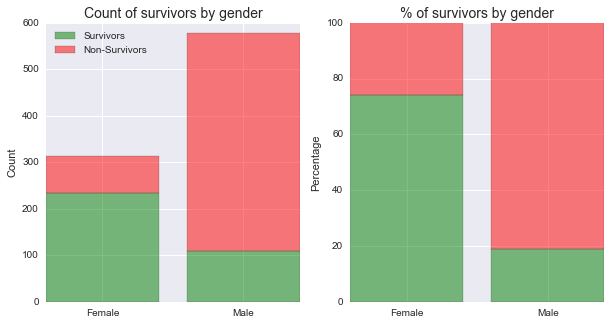

In [136]:
# calculate values for each survival status
survivors_gender = survivors_data.groupby(['Sex']).size().values
non_survivors_gender = non_survivors_data.groupby(['Sex']).size().values

# calculate totals for percentates
totals = survivors_gender + non_survivors_gender

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_gender, totals)*100 
data2_percentages = calculate_percentage(non_survivors_gender, totals)*100 

gender_categories = ['Female', 'Male']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_gender)), survivors_gender, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_gender)), non_survivors_gender, bottom=survivors_gender, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0.4, 1.4], gender_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by gender",fontsize=14)
plt.legend(loc='upper left')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0.4, 1.4],  gender_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by gender",fontsize=14)

The plots and proportions above show that there were a significant more males on board the Titanic compared to the number of females. Whilst the second plot (% of survivors by gender) shows that Females had a higher proportion (74.2%) of survivors compared to the proportion of males (18.9%). This shows that females had a greater rate of survival.

As the P-Value is less than 0.05 the probability of that the age group will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis.

In [137]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Sex'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


As the P-Value is less than 0.05 the probability of that the gender will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis. I also believe that the plots above confirm this result.

## 5.3 Which social class had a better chance of survival?
### Hypothesis
The hypothesis for this question is that the social class does impact the chances of survival

H0 = Social Class has no impact on survivability

HA = Social Class does impact the chances of survivabily

### Count of survivors by class

In [138]:
table = pd.crosstab(titanic_df['Survived'],titanic_df['Pclass'])
print table

Pclass    Lower Class  Middle Class  Upper Class
Survived                                        
False             372            97           80
True              119            87          136


### Proportion of survivors by class

In [139]:
print titanic_df.groupby('Pclass').Survived.mean()

Pclass
Lower Class     0.242363
Middle Class    0.472826
Upper Class     0.629630
Name: Survived, dtype: float64


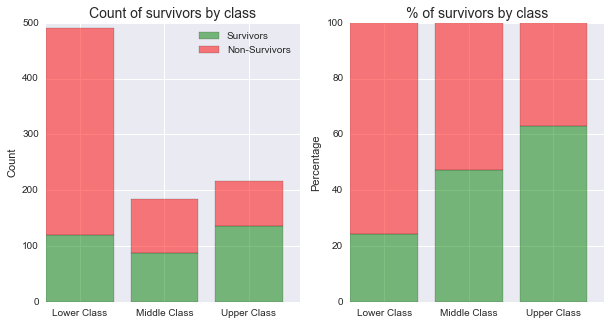

In [140]:
# calculate values for each survival status
survivors_class = survivors_data.groupby(['Pclass']).size().values
non_survivors_class = non_survivors_data.groupby(['Pclass']).size().values

# calculate totals for percentates
totals = survivors_class + non_survivors_class

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_class, totals)*100 
data2_percentages = calculate_percentage(non_survivors_class, totals)*100 


class_categories = ['Lower Class', 'Middle Class', 'Upper Class']


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_class)), survivors_class, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_class)), non_survivors_class, bottom=survivors_class, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0.4, 1.4, 2.4], class_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by class",fontsize=14)
plt.legend(loc='upper right')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0.4, 1.4, 2.4],  class_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by class",fontsize=14)


The graphs above so that whilst the lower class had more passengers, than all classes, and more survivors than the middle class, the lower class had the lowest survival rate. The Upper Class passengers had the highest survival rate

### Hypothesis Test
For this test I will be using the chi-sqaure test for independence

In [141]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['Pclass'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


As the P-Value is less than 0.05 the probability of that the social class will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis. I also believe that the plots above confirm this result.

## 5.4 Which age group had a better chance of survival?
### Hypothesis
The hypothesis for this question is that the age group does impact the chances of survival

H0 = Age Group has no impact on survivability

HA = Age Group does impact the chances of survivabily

### Distribution of Age Groups

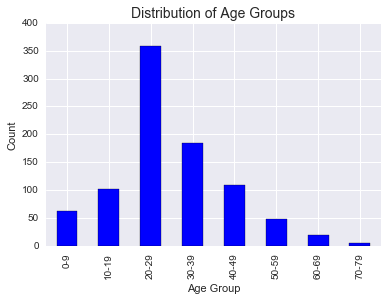

In [142]:
titanic_df.groupby(['age_group']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('Count')
plt.xlabel('Age Group');

From the plot above we can see that the majority of passengers were aged between 20-29

### Proportion of survivors by age group

In [143]:
print titanic_df.groupby(['age_group']).Survived.mean()

age_group
0-9      0.612903
10-19    0.401961
20-29    0.315642
30-39    0.454054
40-49    0.354545
50-59    0.416667
60-69    0.315789
70-79    0.000000
Name: Survived, dtype: float64


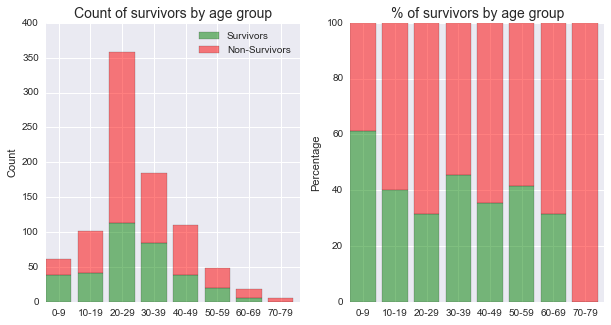

In [144]:
# calculate values for each survival status
survivors_age_group = survivors_data.groupby(['age_group']).size().values
non_survivors_age_group = non_survivors_data.groupby(['age_group']).size().values

# calculate totals for percentates
totals = survivors_age_group + non_survivors_age_group

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_age_group, totals)*100 
data2_percentages = calculate_percentage(non_survivors_age_group, totals)*100 


tick_spacing = np.array(range(len(age_labels)))+0.4


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_age_group)), survivors_age_group, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_age_group)), non_survivors_age_group, bottom=survivors_age_group, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks(tick_spacing, age_labels )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by age group",fontsize=14)
plt.legend(loc='upper right')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks(tick_spacing,  age_labels)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by age group",fontsize=14)

When looking at proportions and percentages of survivors per age group, initially I was suprised by the results, until I thought that this analysis shoudl take into consideration the gender / sex of the passengers as well.

In [145]:
print titanic_df.groupby(['Sex','age_group']).Survived.mean()

Sex     age_group
female  0-9          0.633333
        10-19        0.755556
        20-29        0.681034
        30-39        0.855072
        40-49        0.687500
        50-59        0.888889
        60-69        1.000000
male    0-9          0.593750
        10-19        0.122807
        20-29        0.140496
        30-39        0.215517
        40-49        0.217949
        50-59        0.133333
        60-69        0.133333
        70-79        0.000000
Name: Survived, dtype: float64


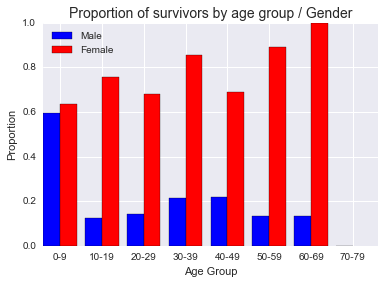

In [146]:
male_data = titanic_df[titanic_df.Sex == "male"].groupby('age_group').Survived.mean().values
female_data = titanic_df[titanic_df.Sex == "female"].groupby('age_group').Survived.mean().values
ax = plt.subplot()
male_plt_position = np.array(range(len(age_labels)))
female_plt_position = np.array(range(len(age_labels)))+0.4
ax.bar(male_plt_position, male_data,width=0.4,label='Male',color='b')
ax.bar(female_plt_position, female_data,width=0.4,label='Female',color='r')
plt.xticks(tick_spacing,  age_labels)
ax.set_ylabel("Proportion")
ax.set_xlabel("Age Group")
ax.set_title("Proportion of survivors by age group / Gender",fontsize=14)
plt.legend(loc='best')
plt.show()

After relooking at the proportion of survivors by age group and gender, the data supports notion of women and children to be given preferential treatment over men. The plot "Proportion of survivors by age group / gender", shows that children (0-9 years old, male and female) and women (all ages) had a much higher proportion of survivors. This supports the notion of the seats in the lifeboats been given to Women and Children first.

### Hypothesis Test
For this test I will be using the chi-sqaure test for independence

In [147]:
table = pd.crosstab([titanic_df['Survived']], titanic_df['age_group'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,29.5389
P-Value,0.0001


As the P-Value is less than 0.05 the probability of that the age group will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis.

# 6. Conclusion
### 6.1 Limitations of dataset
The are a number of limitations with the Titanic Dataset, which are caused by:
- missing data
- only been a sample of the data

The missing data and size of the sample could skew the results for example the missing ages.

In [148]:
print missing_ages.groupby('Sex').size()

Sex
female     53
male      124
dtype: int64


The above shows that there were 53 ages missing for females and 124 ages missing for males. I had a choice with how to handle the missing ages each with their pros and cons.
- delete the rows with the missing ages - this would limit the accuracy of the analysis of the gender and class, however the accuracy of the analysis of the Age factor would be more accurate
- generate ages based on the mean of ages - this could skew the results of the age analysis. In section 4.2, I choose this option, however I based the ages on the average for the Gender and Class.

The size of the sample data could also impact the results as we don't know if this is a random sample or if the selection of the data is biased or unbiased.

## 6.2 Other variables
As with most datasets the more information we have the better it can be analysed. I believe that we could add the following variables:
- passenger or crew - the current dataset doesn't distingush between passenger or crew, however from history we know that a mixture of both survived.
- life boat number - the reason why there were so many fatalities on board the Titanic was due to there not been enough lifeboats. I believe that if we knew the lifeboat number and the capacity of a lifeboat we could determine if it was possible for more people to survive